Features contain NaN or Infinity values.


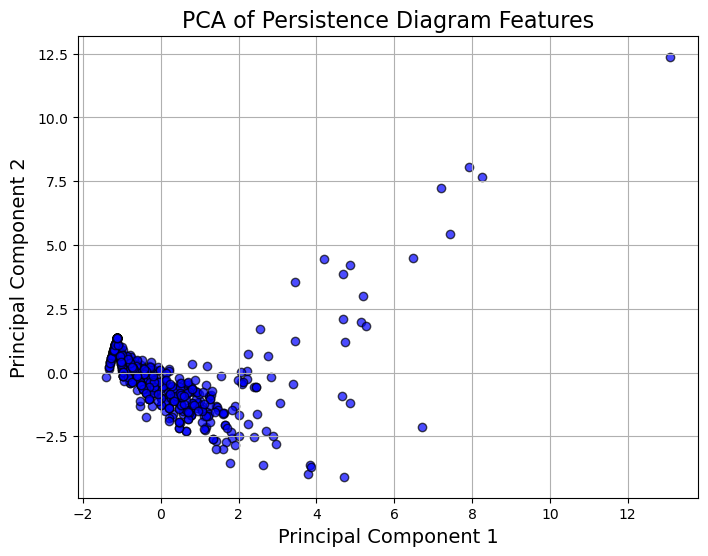

In [5]:
# THIS IS PCA WITHOUT INCLUDING NUMBER OF GOALS IN ADJACENCY MATRIX

import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from ripser import ripser
from sklearn.decomposition import PCA
import os
import re
from sklearn.linear_model import LinearRegression
# Construct adjacency matrix

def construct_adjacency_matrix(game_data):
    G = nx.Graph()

    # Step 1: Find the maximum pass count to normalize edge weights
    max_count = max(pass_info["count"] for player in game_data for pass_info in player["passes"])

    # Step 2: Add nodes for each player
    for player in game_data:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    # Step 3: Add edges with normalized weights (divide by max_count)
    for player in game_data:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            # Normalize edge weight by dividing by the max pass count
            edge_weight = count / max_count

            # Add edge to the graph with normalized weight
            G.add_edge(player1, player2, weight=edge_weight)

    return G
# Load the data from the files

'''file_paths = ['/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890259_Bayern-Munich_2_55.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890259_Hamburger-SV_0_59.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890260_Hoffenheim_1_57.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890261_Borussia-Dortmund_4_76.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890261_Borussia-Mönchengladbach_0_64.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890262_Darmstadt-98_2_64.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890262_Hannover-96_0_45.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890263_FSV-Mainz-05_0_73.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890263_Ingolstadt_0_60.json'
]
'''
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all files
data = [json.load(open(file_path)) for file_path in file_paths]
# Construct the passing network for each match and compute persistence diagrams
persistence_diagrams = []
for match_data in data:
    G = construct_adjacency_matrix(match_data)  # Construct adjacency matrix for each team
    adj_matrix = nx.to_numpy_array(G)  # Convert the graph to an adjacency matrix
    persistence_diagrams.append(ripser(adj_matrix, distance_matrix=True)['dgms'])  # Compute persistence diagram
    
# Extract features from persistence diagrams
def extract_features(persistence_diagrams):
    features = []
    max_len = 0
    
    # First, calculate the maximum length of any feature vector
    for diagram in persistence_diagrams:
        if diagram:  # If the diagram is not empty
            diagram = np.array(diagram[0])  # Diagram[0] contains the points
            lifespan = diagram[:, 1] - diagram[:, 0]  # Calculate lifespan (death - birth)
            features.append(lifespan)
            max_len = max(max_len, len(lifespan))  # Track the maximum length
        else:
            features.append(np.zeros(1))  # In case the diagram is empty, append a zero vector
    
    # Now, pad all features to the maximum length
    padded_features = []
    for feature in features:
        if len(feature) < max_len:
            # Pad with zeros to make the feature vector the same length
            padded_features.append(np.pad(feature, (0, max_len - len(feature)), mode='constant'))
        else:
            padded_features.append(feature)
    
    return np.array(padded_features)

# Extract features from persistence diagrams
features = extract_features(persistence_diagrams)
# Standardize the features
scaler = StandardScaler()

# Check for NaN or infinity values in the features
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Features contain NaN or Infinity values.")
    # Option 1: Replace NaN or infinity with a constant, e.g., the mean or 0
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

    # Option 2: Alternatively, you can replace with the mean or drop problematic rows (depending on your choice)
    # For example:
    # features = np.nan_to_num(features, nan=np.nanmean(features), posinf=0, neginf=0)

# Scale the features now that we have handled NaN or Infinity values
features_scaled = scaler.fit_transform(features)

# Step 4: Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
features_pca = pca.fit_transform(features_scaled)

# Scatter plot of the PCA-transformed features
plt.figure(figsize=(8, 6))

# Assuming `features_pca` contains the PCA-transformed features
plt.scatter(features_pca[:, 0], features_pca[:, 1], c='blue', edgecolor='k', alpha=0.7)

# Add labels and titles
plt.title("PCA of Persistence Diagram Features", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.grid(True)

# Optional: Annotate points if you want to see which match they correspond to
# for i, file_path in enumerate(file_paths):
#     plt.text(features_pca[i, 0], features_pca[i, 1], os.path.basename(file_path).split('_')[0], fontsize=8)

plt.show()


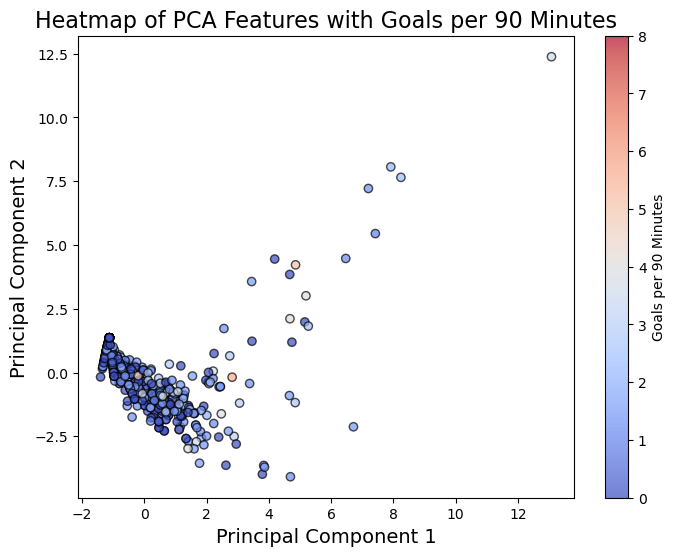

In [6]:
# Function to extract the number of goals and time from the filename
def extract_goals_and_time(file_name):
    match = re.search(r"_(\d+)_(\d+)\.json", file_name)
    if match:
        goals = int(match.group(1))  # Extract goals
        time = int(match.group(2))  # Extract time
        return goals / time * 90  # Normalize goals to a 90-minute game
    return 0

# Extract goals per 90 minutes for each match
goals_per_90 = [extract_goals_and_time(os.path.basename(file_path)) for file_path in file_paths]

# Create a heatmap based on PCA components and goals scored
plt.figure(figsize=(8, 6))

# Using a scatter plot with a color map based on goals per 90 minutes
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=goals_per_90, cmap='coolwarm', edgecolor='k', alpha=0.7)

# Add a color bar to show the scale of goals per 90 minutes
cb = plt.colorbar(label='Goals per 90 Minutes')

# Add labels and title
plt.title("Heatmap of PCA Features with Goals per 90 Minutes", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)

plt.grid(False)  # Turn off grid for heatmap

plt.show()

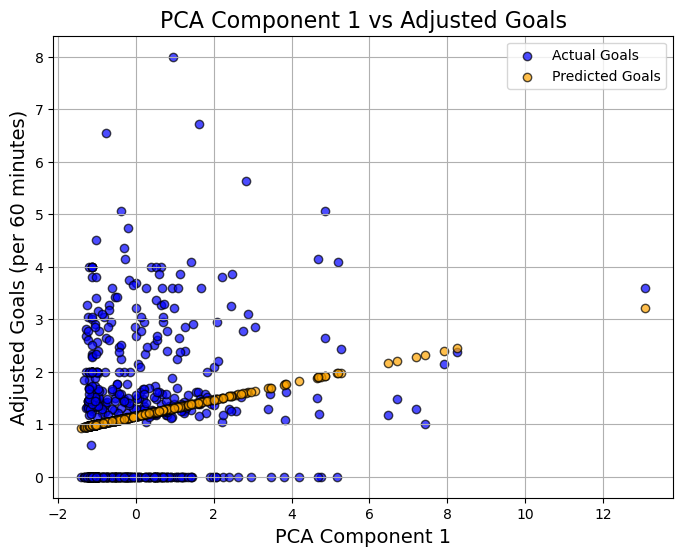

In [7]:
# Perform regression of PCA component 1 against adjusted goals (if not already done)
pca_1 = features_pca[:, 0].reshape(-1, 1)  # Use PCA component 1 as predictor
regressor = LinearRegression()
regressor.fit(pca_1, goals_per_90)

# Predict values for visualization
adjusted_goals_pred = regressor.predict(pca_1)

# Visualize both actual and predicted goals
plt.figure(figsize=(8, 6))
plt.scatter(pca_1, goals_per_90, color='blue', edgecolor='k', alpha=0.7, label="Actual Goals")
plt.scatter(pca_1, adjusted_goals_pred, color='orange', edgecolor='k', alpha=0.7, label="Predicted Goals")
plt.title("PCA Component 1 vs Adjusted Goals", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("Adjusted Goals (per 60 minutes)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

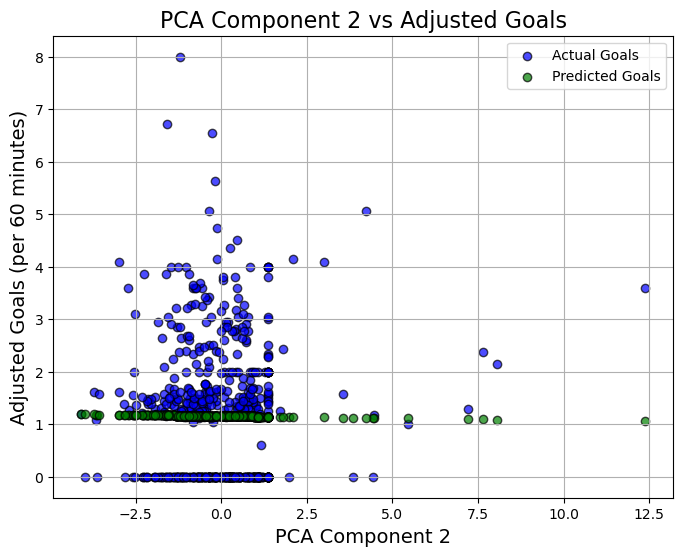

In [8]:
# Perform regression of PCA component 2 against adjusted goals (if not already done)
pca_2 = features_pca[:, 1].reshape(-1, 1)  # Use PCA component 2 as predictor
regressor_pca2 = LinearRegression()
regressor_pca2.fit(pca_2, goals_per_90)

# Predict values for visualization
adjusted_goals_pred_pca2 = regressor_pca2.predict(pca_2)

# Visualize both actual and predicted goals for PCA Component 2
plt.figure(figsize=(8, 6))
plt.scatter(pca_2, goals_per_90, color='blue', edgecolor='k', alpha=0.7, label="Actual Goals")
plt.scatter(pca_2, adjusted_goals_pred_pca2, color='green', edgecolor='k', alpha=0.7, label="Predicted Goals")
plt.title("PCA Component 2 vs Adjusted Goals", fontsize=16)
plt.xlabel("PCA Component 2", fontsize=14)
plt.ylabel("Adjusted Goals (per 60 minutes)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

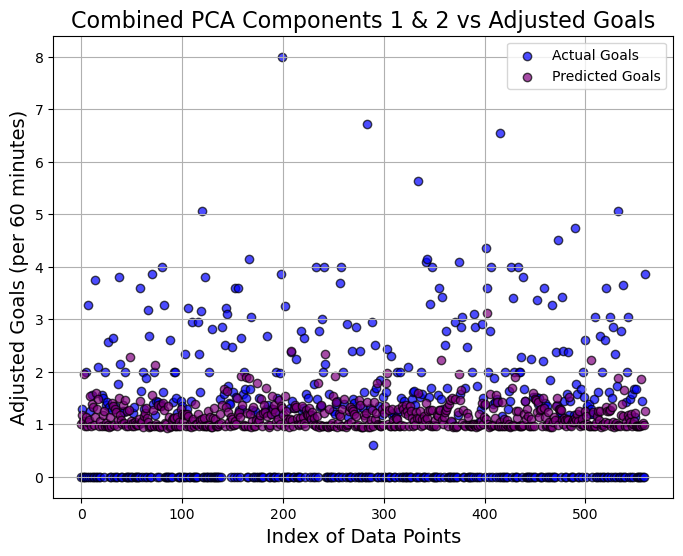

In [9]:
# Combine PCA Component 1 and 2 for multiple linear regression
pca_combined = features_pca[:, :2]  # Use both PCA Component 1 and Component 2

# Perform regression with both components
regressor_combined = LinearRegression()
regressor_combined.fit(pca_combined, goals_per_90)

# Predict values for visualization
adjusted_goals_pred_combined = regressor_combined.predict(pca_combined)

# Visualize both actual and predicted goals for PCA Components 1 & 2 combined
plt.figure(figsize=(8, 6))
plt.scatter(range(len(goals_per_90)), goals_per_90, color='blue', edgecolor='k', alpha=0.7, label="Actual Goals")
plt.scatter(range(len(goals_per_90)), adjusted_goals_pred_combined, color='purple', edgecolor='k', alpha=0.7, label="Predicted Goals")
plt.title("Combined PCA Components 1 & 2 vs Adjusted Goals", fontsize=16)
plt.xlabel("Index of Data Points", fontsize=14)
plt.ylabel("Adjusted Goals (per 60 minutes)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


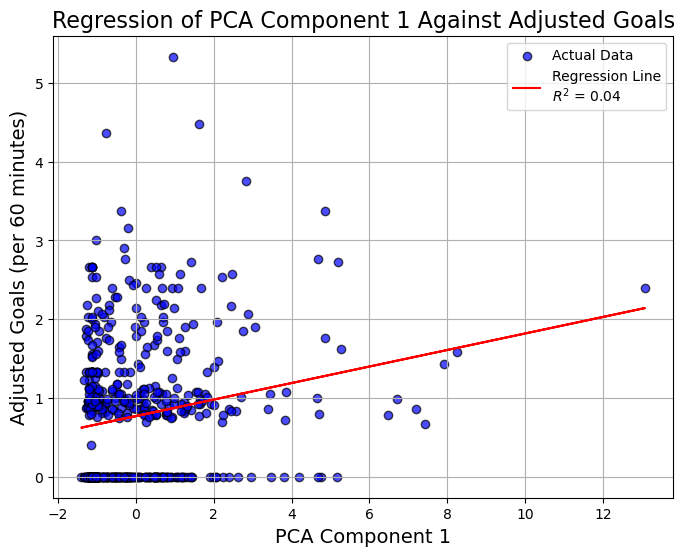

In [10]:
import re
from sklearn.linear_model import LinearRegression

# Extract goals and time played from filenames
def extract_goals_and_time(file_paths):
    goals_time = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = re.search(r'_(\d+)_(\d+)\.json$', filename)
        if match:
            goals = int(match.group(1))
            time = int(match.group(2))
            goals_time.append((goals, time))
    return goals_time

# Compute adjusted goals (goals per 60 minutes)
def compute_adjusted_goals(goals_time):
    adjusted_goals = []
    for goals, time in goals_time:
        adjusted_goal_rate = (goals / time) * 60  # Scale goals to 60-minute equivalent
        adjusted_goals.append(adjusted_goal_rate)
    return np.array(adjusted_goals)

# Extract goals and time
goals_time = extract_goals_and_time(file_paths)
adjusted_goals = compute_adjusted_goals(goals_time)

# Perform regression of PCA component 1 against adjusted goals
pca_1 = features_pca[:, 0].reshape(-1, 1)  # Use PCA component 1 as predictor
regressor = LinearRegression()
regressor.fit(pca_1, adjusted_goals)

# Predict values for visualization
adjusted_goals_pred = regressor.predict(pca_1)

# Visualize regression
plt.figure(figsize=(8, 6))
plt.scatter(pca_1, adjusted_goals, color='blue', edgecolor='k', alpha=0.7, label="Actual Data")
plt.plot(pca_1, adjusted_goals_pred, color='red', label=f"Regression Line\n$R^2$ = {regressor.score(pca_1, adjusted_goals):.2f}")
plt.title("Regression of PCA Component 1 Against Adjusted Goals", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("Adjusted Goals (per 60 minutes)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


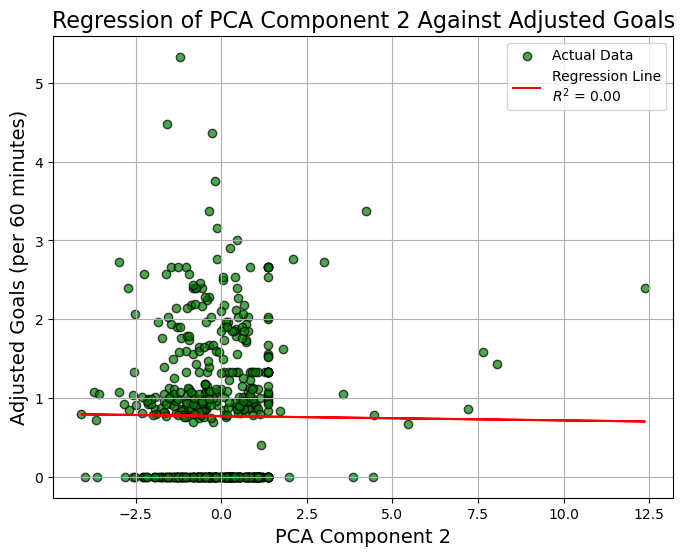

In [11]:
# Perform regression of PCA component 2 against adjusted goals
pca_2 = features_pca[:, 1].reshape(-1, 1)  # Use PCA component 2 as predictor
regressor_pca2 = LinearRegression()
regressor_pca2.fit(pca_2, adjusted_goals)

# Predict values for visualization
adjusted_goals_pred_pca2 = regressor_pca2.predict(pca_2)

# Visualize regression
plt.figure(figsize=(8, 6))
plt.scatter(pca_2, adjusted_goals, color='green', edgecolor='k', alpha=0.7, label="Actual Data")
plt.plot(pca_2, adjusted_goals_pred_pca2, color='red', label=f"Regression Line\n$R^2$ = {regressor_pca2.score(pca_2, adjusted_goals):.2f}")
plt.title("Regression of PCA Component 2 Against Adjusted Goals", fontsize=16)
plt.xlabel("PCA Component 2", fontsize=14)
plt.ylabel("Adjusted Goals (per 60 minutes)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


Combined Model R^2: 0.04
Coefficients: [ 0.10489258 -0.00547949]
Intercept: 0.7699809341944531


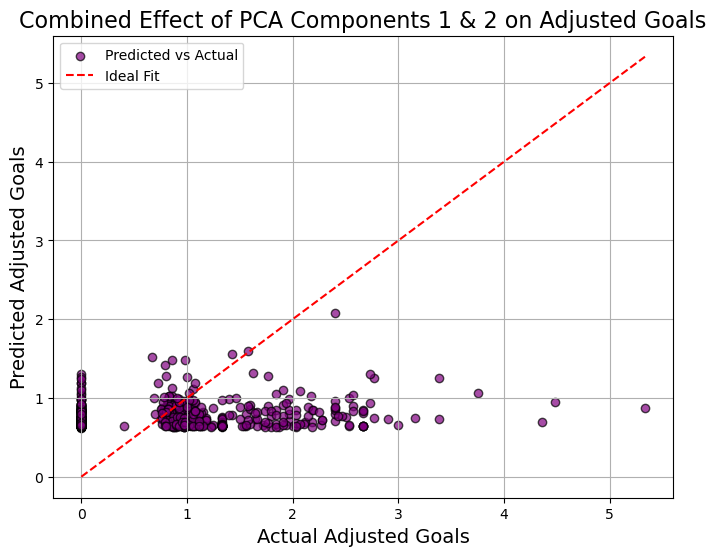

In [12]:
# Combine PCA Component 1 and 2 for multiple linear regression
pca_combined = features_pca[:, :2]  # Use both PCA Component 1 and Component 2

# Perform regression with both components
regressor_combined = LinearRegression()
regressor_combined.fit(pca_combined, adjusted_goals)

# Predict values for visualization
adjusted_goals_pred_combined = regressor_combined.predict(pca_combined)

# Print model statistics
r2_combined = regressor_combined.score(pca_combined, adjusted_goals)
print(f"Combined Model R^2: {r2_combined:.2f}")
print(f"Coefficients: {regressor_combined.coef_}")
print(f"Intercept: {regressor_combined.intercept_}")

# Visualization of predictions vs actual adjusted goals
plt.figure(figsize=(8, 6))
plt.scatter(adjusted_goals, adjusted_goals_pred_combined, color='purple', edgecolor='k', alpha=0.7, label="Predicted vs Actual")
plt.plot([min(adjusted_goals), max(adjusted_goals)], [min(adjusted_goals), max(adjusted_goals)], color='red', linestyle='--', label="Ideal Fit")
plt.title("Combined Effect of PCA Components 1 & 2 on Adjusted Goals", fontsize=16)
plt.xlabel("Actual Adjusted Goals", fontsize=14)
plt.ylabel("Predicted Adjusted Goals", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
